In [1]:
"""Computing and visualizing gender shifts for gendered settings (gendered prompts)
= for a given topic/model or overall, proportion of the nb of times the gender given in the prompt is overridden
(Masculine Prompt to Feminine/Ambiguous generation) + (Feminine prompt to Masc/Ambiguous Prompt) / All Generations

Note: Copy of gender_shift-it but with paths for Italian."""

import pandas as pd
import numpy as np

modeles = ["cerbero-7b", "xglm-2"]

dic_df = {}
for modele in modeles:
    df = pd.read_csv(f"../../annotated_texts/IT/gendered/annotated-coverletter_gendered_it_{modele}.csv")
    df["model"]=modele
    dic_df[modele] = df
    
data_genre = pd.concat(list(dic_df.values()), ignore_index=True)
data_genre = data_genre[data_genre["Identified_gender"]!="incomplet"]
data_genre.replace({"Ambigu":"Ambiguous", "Fem":"Feminine", "Masc":"Masculine", "Neutre":"Neutral"}, inplace=True)
topics = list(set(data_genre["theme"]))


In [2]:
def prompt_gender(gender, df):
    """Returns the likelihood that the gender of the prompt is overridden, per gender"""
    prompt_g = df[df['genre'].astype(str).str.contains(gender)]
    #return prompt_g["Identified_gender"].value_counts(normalize=True)
    pct = prompt_g["Identified_gender"].value_counts(normalize=True)
    if gender=="masc":
        opposite_gender="Feminine"
    else:
        opposite_gender="Masculine"

    return (pct.get('Ambiguous',0)+pct.get(opposite_gender,0))#*100 #%

## Results for masculine prompts

In [3]:
# total
prompt_gender("masc", data_genre)

0.020146520146520144

In [4]:
# per model
res_mod = {}
for modele in modeles:
    data_model = data_genre[data_genre['model']==modele]
    res_mod[modele] = round(prompt_gender("masc", data_model),2)
print(res_mod)

{'cerbero-7b': 0.02, 'xglm-2': 0.02}


In [5]:
# per professional field
res_dom = {}
for topic in topics:
    data_topic = data_genre[data_genre['theme']==topic]
    res_dom[topic] = round(prompt_gender("masc", data_topic),2)

from collections import Counter
counter = Counter(res_dom)
top = counter.most_common()
# Profesional fields resulting in the highest nb of feminine or ambiguous generations whereas the prompt is masc

print("Domaines professionnels qui résultent en le + de générations fém/amb alors que le prompt est masc : \t", top[:10])
print("\n\nDomaines professionnels qui résultent en le - de générations fém/amb alors que le prompt est masc : \t", top[-10:])

Domaines professionnels qui résultent en le + de générations fém/amb alors que le prompt est masc : 	 [('attività degli studi odontoiatrici', 0.17), ('attività delle agenzie di viaggio', 0.1), ('traduzione e interpretariato', 0.09), ('attività generali di amministrazione pubblica', 0.09), ('costruzione di ponti e gallerie', 0.08), ('servizi degli studi medici di medicina generale', 0.08), ('installazione di impianti elettrici', 0.08), ('attività di musei', 0.08), ('affari esteri', 0.08), ('attività delle banche centrali', 0.08)]


Domaines professionnels qui résultent en le - de générations fém/amb alors que le prompt est masc : 	 [('attività di produzione cinematografica, di video e di programmi televisivi', 0), ('acquacoltura marina', 0), ('servizi investigativi privati', 0), ('pesca marina', 0), ('lavori di costruzione e installazione', 0), ('ordine pubblico e sicurezza nazionale', 0), ("attività dei servizi connessi alle tecnologie dell'informatica", 0), ('servizi ospedalieri', 0),

## Results for feminine prompts

In [6]:
# total
prompt_gender("fem", data_genre)

0.1853146853146853

In [7]:
# per model
res_mod = {}
for modele in modeles:
    data_model = data_genre[data_genre['model']==modele]
    res_mod[modele] = round(prompt_gender("fem", data_model),2)
print(res_mod)

{'cerbero-7b': 0.25, 'xglm-2': 0.12}


In [8]:
# per professional field
res_dom = {}
for topic in topics:
    data_topic = data_genre[data_genre['theme']==topic]
    res_dom[topic] = round(prompt_gender("fem", data_topic),2)

from collections import Counter
counter = Counter(res_dom)
top = counter.most_common()
# Profesional fields resulting in the highest nb of masculine or ambiguous generations whereas the prompt is fem
print("Domaines professionnels qui résultent en le + de générations masc/amb alors que prompt fém : \t", top[:10])
print("\n\nDomaines professionnels qui résultent en le - de générations masc/amb alors que prompt fém : \t", top[-10:])

Domaines professionnels qui résultent en le + de générations masc/amb alors que prompt fém : 	 [('servizi degli studi medici di medicina generale', 0.45), ('servizi veterinari', 0.45), ('pesca marina', 0.45), ('fabbricazione di strumenti musicali', 0.42), ('fusione di acciaio', 0.42), ('allevamento di bovini da latte', 0.36), ('commercio di altri autoveicoli', 0.33), ('lavori di costruzione e installazione', 0.33), ('attività delle banche centrali', 0.33), ('attività di produzione cinematografica, di video e di programmi televisivi', 0.27)]


Domaines professionnels qui résultent en le - de générations masc/amb alors que prompt fém : 	 [('ricerca e sviluppo sperimentale nel campo delle scienze sociali e umanistiche', 0.08), ('attività editoriali', 0.08), ('fabbricazione di profumi e cosmetici', 0.08), ('servizi di assistenza sanitaria', 0.08), ('servizi di asili nido', 0.08), ('traduzione e interpretariato', 0), ('attività dei vigili del fuoco e della protezione civile', 0), ('attività

## Overall results (GS in either direction)

In [9]:
def gender_shift(df):
    """Compute the Gender Shift (= likelihood that the gender given in the prompt is overridden, i.e. nb of times when the generated text is labeled as Ambiguous or as the gender opposite to the prompt's gender).

    Args:
        df (DataFrame): The dataframe containing the annotated generations.

    Returns:
        (int) The resulting Gender Shift
    """    #df.replace({"['Prompt_masc']":"Masculine", "['Prompt_fém']":"Feminine"}, inplace=True)

    df['gender_shift'] = np.where((df['genre'] != df['Identified_gender']) & (df['genre'] == "Neutral") & (df['Identified_gender'] != "Neutral") & (df['Identified_gender']!="incomplet"), 1, 0)
    
    df = df[df.genre != "Neutral"]
    df['gender_shift'] = np.where((df['genre'] != df['Identified_gender']) & (df['Identified_gender'] != "Neutral") & (df['Identified_gender']!="incomplet"), 1, 0)

    df.to_csv("gender_shift_noneutral_it.csv")
    return sum(df['gender_shift'])/len(df['gender_shift'])

In [10]:
"""To exclude gender-inclusive prompts"""
data_genre.replace({"masc":"Masculine", "fem":"Feminine", "inclus":"Neutral"}, inplace=True)
gender_shift(data_genre)

/tmp/ipykernel_59157/2423580259.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender_shift'] = np.where((df['genre'] != df['Identified_gender']) & (df['Identified_gender'] != "Neutral") & (df['Identified_gender']!="incomplet"), 1, 0)


0.10465116279069768

In [11]:
res_mod = {}
for modele in modeles:
    data_model = data_genre[data_genre['model']==modele]
    res_mod[modele] = round(gender_shift(data_model),3)
print(res_mod)

{'cerbero-7b': 0.135, 'xglm-2': 0.069}


/tmp/ipykernel_59157/2423580259.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender_shift'] = np.where((df['genre'] != df['Identified_gender']) & (df['genre'] == "Neutral") & (df['Identified_gender'] != "Neutral") & (df['Identified_gender']!="incomplet"), 1, 0)
/tmp/ipykernel_59157/2423580259.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender_shift'] = np.where((df['genre'] != df['Identified_gender']) & (df['Identified_gender'] != "Neutral") & (df['Identified_gender']!="incomplet"),

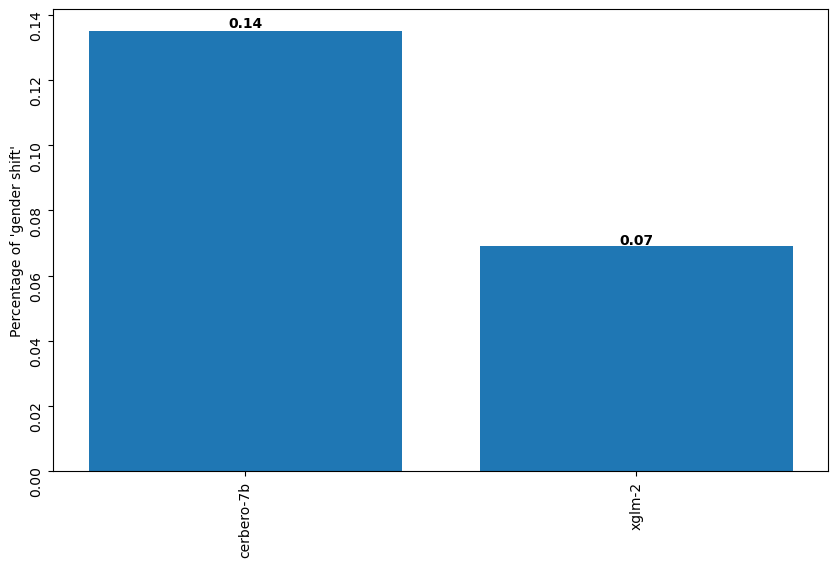

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(list(res_mod.keys()), list(res_mod.values()))
ax.tick_params(labelrotation=90) 
ax.set_ylabel("Percentage of 'gender shift'")
#ax.set_title('Problèmes de qualité de données')
i = 0
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2,
             y+height*1.01,
             round(list(res_mod.values())[i],2),
             ha='center',
             weight='bold')
    i+=1
    
#plt.savefig("fig/moy_gap_topic_model.png")

In [13]:
# per professional field
res_dom = {}
for topic in topics:
    data_topic = data_genre[data_genre['theme']==topic]
    res_dom[topic] = round(gender_shift( data_topic),2)

from collections import Counter
counter = Counter(res_dom)
top = counter.most_common()
print("Domaines professionnels qui résultent en le + de générations avec chgt de genre : \t", top[:10])
print("\n\nDomaines professionnels qui résultent en le - de générations avec chgt de genre : \t", top[-10:])

Domaines professionnels qui résultent en le + de générations avec chgt de genre : 	 [('servizi degli studi medici di medicina generale', 0.26), ('fabbricazione di strumenti musicali', 0.24), ('servizi veterinari', 0.22), ('pesca marina', 0.22), ('fusione di acciaio', 0.21), ('attività delle banche centrali', 0.21), ('allevamento di bovini da latte', 0.18), ('lavori di costruzione e installazione', 0.18), ('attività generali di amministrazione pubblica', 0.18), ('commercio di altri autoveicoli', 0.17)]


Domaines professionnels qui résultent en le - de générations avec chgt de genre : 	 [('attività sportive', 0.05), ('servizi di assistenza sanitaria', 0.05), ('servizi di asili nido', 0.05), ('traduzione e interpretariato', 0.04), ('attività editoriali', 0.04), ('realizzazione di coperture', 0.04), ('telecomunicazione', 0.04), ('attività dei vigili del fuoco e della protezione civile', 0.0), ('servizi investigativi privati', 0.0), ('ordine pubblico e sicurezza nazionale', 0.0)]


/tmp/ipykernel_59157/2423580259.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender_shift'] = np.where((df['genre'] != df['Identified_gender']) & (df['genre'] == "Neutral") & (df['Identified_gender'] != "Neutral") & (df['Identified_gender']!="incomplet"), 1, 0)
/tmp/ipykernel_59157/2423580259.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender_shift'] = np.where((df['genre'] != df['Identified_gender']) & (df['Identified_gender'] != "Neutral") & (df['Identified_gender']!="incomplet"),

In [14]:
# per model AND field 
res_dom = {}
data_model = data_genre[data_genre['model']=="cerbero-7b"]
for topic in topics:
    data_topic = data_model[data_model['theme']==topic]
    res_dom[topic] = round(gender_shift(data_topic),2)

from collections import Counter
counter = Counter(res_dom)
top = counter.most_common()
print("Domaines professionnels qui résultent en le + de générations avec chgt de genre : \t", top[:10])
print("\n\nDomaines professionnels qui résultent en le - de générations avec chgt de genre : \t", top[-10:])

/tmp/ipykernel_59157/2423580259.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender_shift'] = np.where((df['genre'] != df['Identified_gender']) & (df['genre'] == "Neutral") & (df['Identified_gender'] != "Neutral") & (df['Identified_gender']!="incomplet"), 1, 0)
/tmp/ipykernel_59157/2423580259.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender_shift'] = np.where((df['genre'] != df['Identified_gender']) & (df['Identified_gender'] != "Neutral") & (df['Identified_gender']!="incomplet"),

Domaines professionnels qui résultent en le + de générations avec chgt de genre : 	 [('fabbricazione di strumenti musicali', 0.33), ('fusione di acciaio', 0.33), ('pesca marina', 0.33), ('attività delle banche centrali', 0.33), ('commercio di altri autoveicoli', 0.25), ('edizione di giochi per computer', 0.25), ('attività delle agenzie di viaggio', 0.25), ('allevamento di bovini da latte', 0.25), ("attività dei servizi connessi alle tecnologie dell'informatica", 0.25), ('giustizia ed attività giudiziarie', 0.25)]


Domaines professionnels qui résultent en le - de générations avec chgt de genre : 	 [('telecomunicazione', 0.08), ('acquacoltura marina', 0.08), ('servizi ospedalieri', 0.08), ('attività ricreative e di divertimento', 0.08), ('attività degli studi legali e notarili', 0.0), ('fabbricazione di aeromobili', 0.0), ('attività dei vigili del fuoco e della protezione civile', 0.0), ('ricerche di mercato e sondaggi di opinione', 0.0), ('servizi investigativi privati', 0.0), ('ordine

In [15]:
res_dom = {}
data_model = data_genre[data_genre['model']=="xglm-2"]
for topic in topics:
    data_topic = data_model[data_model['theme']==topic]
    res_dom[topic] = round(gender_shift( data_topic),2)

from collections import Counter
counter = Counter(res_dom)
top = counter.most_common()
print("Domaines professionnels qui résultent en le + de générations avec chgt de genre : \t", top[:10])
print("\n\nDomaines professionnels qui résultent en le - de générations avec chgt de genre : \t", top[-10:])

Domaines professionnels qui résultent en le + de générations avec chgt de genre : 	 [('servizi degli studi medici di medicina generale', 0.36), ('servizi veterinari', 0.27), ('ricerche di mercato e sondaggi di opinione', 0.22), ('fabbricazione di aeromobili', 0.2), ('lavori di costruzione e installazione', 0.2), ('servizi ospedalieri', 0.18), ('attività di musei', 0.17), ('attività di produzione cinematografica, di video e di programmi televisivi', 0.14), ('attività degli studi legali e notarili', 0.11), ('attività fotografiche', 0.11)]


Domaines professionnels qui résultent en le - de générations avec chgt de genre : 	 [('attività degli studi odontoiatrici', 0.0), ('attività sportive', 0.0), ('edizione di libri', 0.0), ('servizi di assistenza sanitaria', 0.0), ('servizi di asili nido', 0.0), ('telecomunicazione', 0.0), ('servizi investigativi privati', 0.0), ('ordine pubblico e sicurezza nazionale', 0.0), ("attività dei servizi connessi alle tecnologie dell'informatica", 0.0), ('gius

/tmp/ipykernel_59157/2423580259.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender_shift'] = np.where((df['genre'] != df['Identified_gender']) & (df['genre'] == "Neutral") & (df['Identified_gender'] != "Neutral") & (df['Identified_gender']!="incomplet"), 1, 0)
/tmp/ipykernel_59157/2423580259.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender_shift'] = np.where((df['genre'] != df['Identified_gender']) & (df['Identified_gender'] != "Neutral") & (df['Identified_gender']!="incomplet"),

In [16]:
df_top = pd.DataFrame(top[:10]+top[-10:], columns =['Field', 'Gender shift prob'])

(0.0, 1.0)

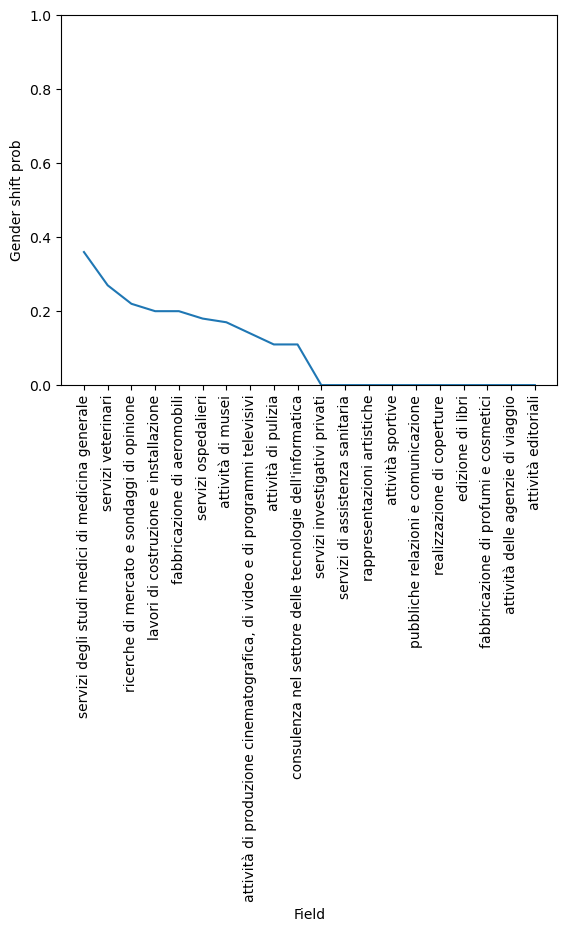

In [74]:
import seaborn as sns
ax = sns.lineplot(data=df_top, x="Field", y="Gender shift prob", )
ax.tick_params(axis='x', rotation=90)
ax.set_ylim(0.0, 1.0)